<a href="https://colab.research.google.com/github/Xuwei-Tang/graduation-project/blob/main/DensityVisDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/VisDrone2020-CC.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/VisDrone2020-CC.zip
   creating: /content/drive/MyDrive/VisDrone2020-CC/
   creating: /content/drive/MyDrive/VisDrone2020-CC/test/
   creating: /content/drive/MyDrive/VisDrone2020-CC/test/annotations/
   creating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/
   creating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00001.jpg  
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00002.jpg  
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00003.jpg  
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00004.jpg  
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00005.jpg  
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00006.jpg  
  inflating: /content/drive/MyDrive/VisDrone2020-CC/test/sequences/00011/00007.jpg  
  inflating: /content/drive/M

In [2]:
#set the root to the Shanghai dataset you download
root = '/content/drive/MyDrive/VisDrone2020-CC'

In [3]:
import os
#now generate the ShanghaiA's ground truth
train = os.path.join(root,'train/sequences')
test = os.path.join(root,'test/sequences')
path_sets = [train,test]

In [4]:
print(path_sets)

['/content/drive/MyDrive/VisDrone2020-CC/train/sequences', '/content/drive/MyDrive/VisDrone2020-CC/test/sequences']


les deux datasets

In [2]:
img_folder_paths = []
for path in path_sets:
  for path, dirs, files in os.walk(path):
    for d in dirs:
      img_folder_paths.append(d)
    break
print(len(img_folder_paths))

NameError: name 'path_sets' is not defined

train dataset

In [23]:
img_folder_paths=[]
for path, dirs, files in os.walk(path_sets[0]):
    dirs.sort(key=lambda x: int(x))  # 🔹按照数字排序
    for d in dirs:
      img_folder_paths.append(path_sets[0]+"/"+d)
print(len(img_folder_paths))

82


In [24]:
import matplotlib.pyplot as plt

In [25]:
for img_folder_path in img_folder_paths:
    print (img_folder_path)

/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00001
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00002
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00003
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00004
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00005
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00006
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00007
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00008
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00009
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00010
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00012
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00013
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00014
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00019
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00020
/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00021
/content/drive/MyDrive/V

In [26]:
from google.colab.patches import cv2_imshow

/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00001
00001.jpg
/content/drive/MyDrive/VisDrone2020-CC/train/annotations/00001.txt


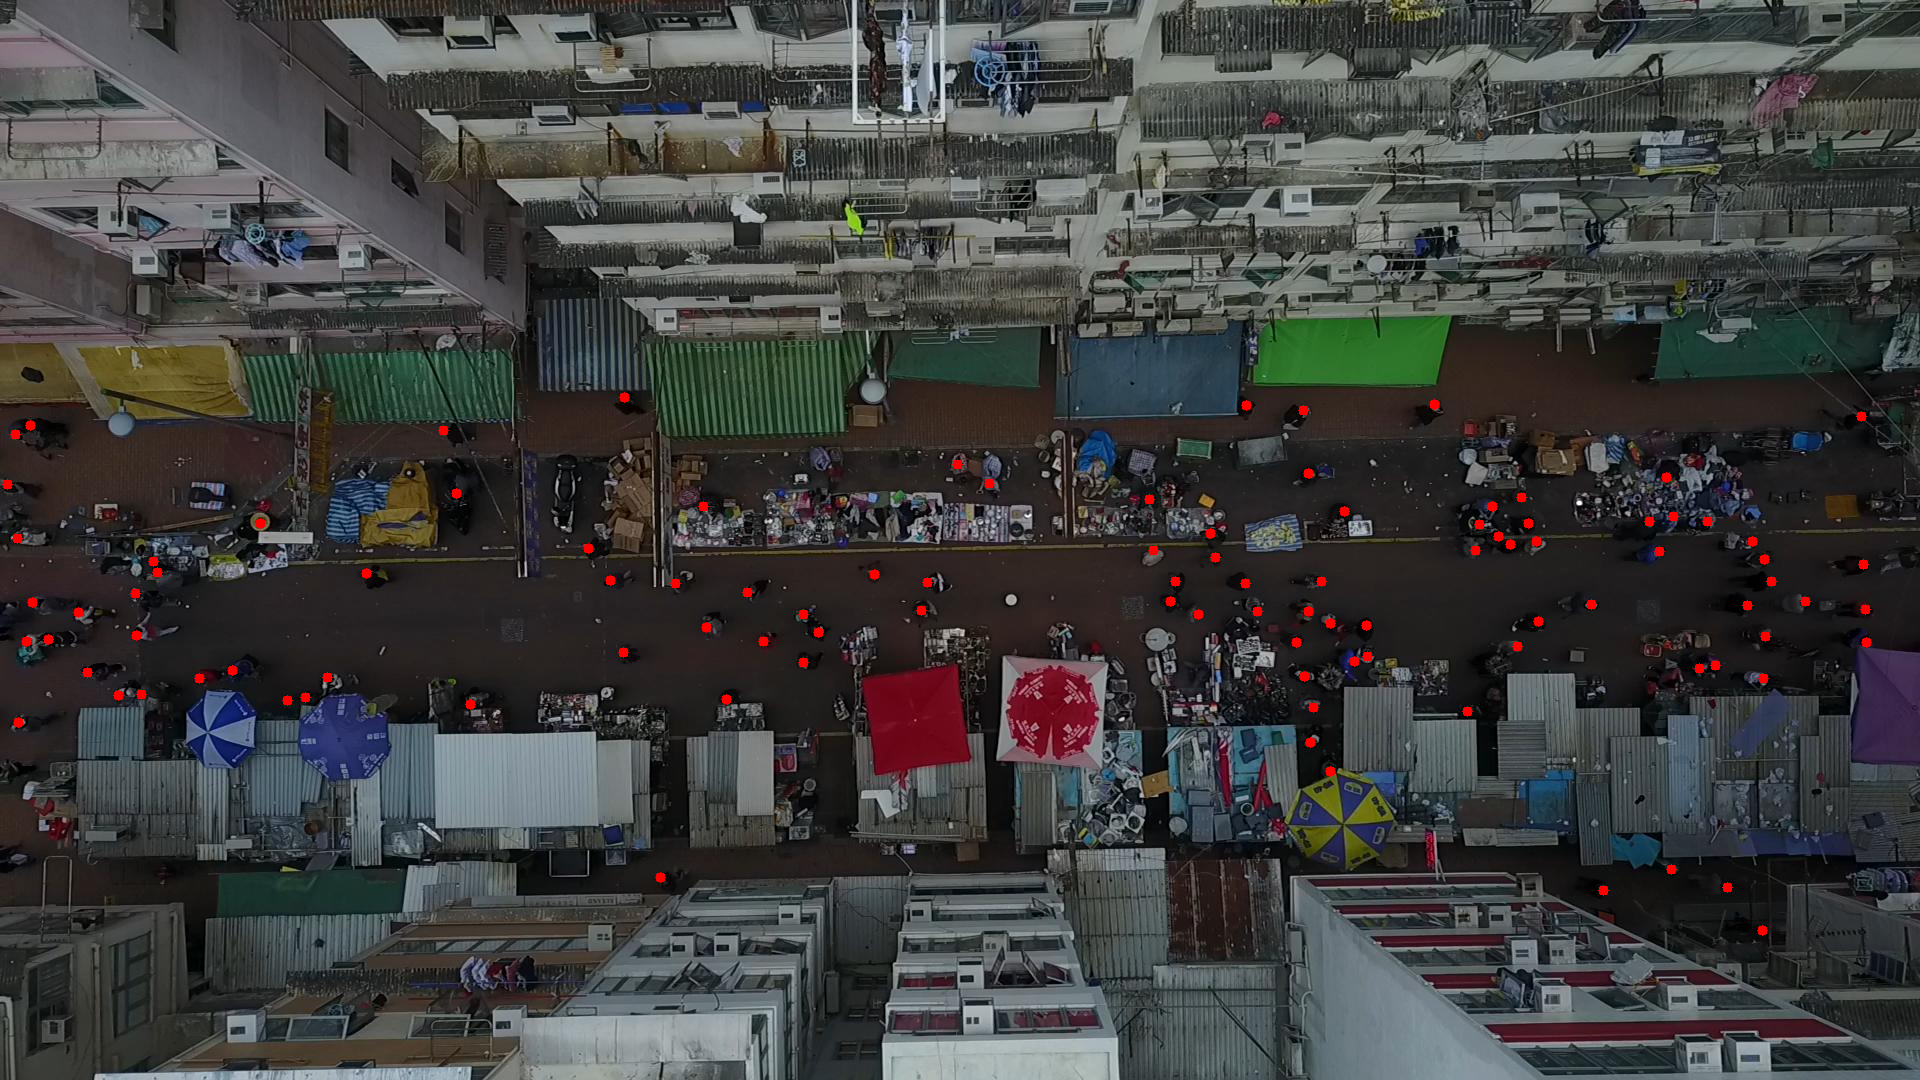

In [27]:
import cv2
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      img= cv2.imread(img_folder_path+"/"+img_path)
      print(img_path)
      annotation = img_path.replace('.jpg','')
      pos = 0
      for nbr in annotation:
        if nbr != '0':
          #print(nbr)
          annotation = annotation[pos:]
          break
        pos+=1
      #print(annotation)
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      #plt.imshow(img)
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        #print(ligne.strip())
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        #print(line)
        if line[0] == int(annotation):
          #print(line[0], int(annotation))
          #plt.scatter([line[1]], line[2])
          img = cv2.circle(img,(line[1],line[2]), 5, (0,0,255), -1)


      break
  break
cv2_imshow(img)

**Awesome CC density map generation**

In [3]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
#from image import *
#from model import CSRNet
import torch
%matplotlib inline

In [4]:
import cupy as cp
from cupyx.scipy.ndimage import gaussian_filter as cupy_gaussian_filter
from scipy.spatial import KDTree
import numpy as np

def gaussian_filter_density2(gt):
    # 将 gt 转换为 Cupy 数组
    gt_cp = cp.asarray(gt)
    print(gt_cp.shape)

    # 在 GPU 上初始化密度图
    density = cp.zeros(gt_cp.shape, dtype=cp.float32)

    gt_count = cp.count_nonzero(gt_cp)
    if gt_count == 0:
        return cp.asnumpy(density)

    # 提取标注点（x, y）坐标；注意这里转换为 NumPy 数组供 KDTree 使用
    nonzero_y, nonzero_x = cp.nonzero(gt_cp)
    pts = np.array(list(zip(cp.asnumpy(nonzero_x), cp.asnumpy(nonzero_y))))

    # 构建 KDTree（在 CPU 上）
    leafsize = 2048
    tree = KDTree(pts.copy(), leafsize=leafsize)
    distances, locations = tree.query(pts, k=4)

    print('Generating density map...')
    # 遍历所有标注点，在 GPU 上构造单点激活图并进行高斯滤波
    for i, pt in enumerate(pts):
        # 在 GPU 上创建一个和 gt 大小相同的空图
        pt2d = cp.zeros(gt_cp.shape, dtype=cp.float32)
        # 注意索引顺序：pt[0] 是 x 坐标，pt[1] 是 y 坐标
        pt2d[int(pt[1]), int(pt[0])] = 1.

        # 动态计算 sigma（与原方法相同）
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = cp.average(cp.array(gt_cp.shape, dtype=cp.float32)) / 4.

        # 使用 Cupy 的高斯滤波（在 GPU 上执行）
        filtered = cupy_gaussian_filter(pt2d, sigma, mode='constant')
        density += filtered

    print('Done.')
    return cp.asnumpy(density)



In [5]:
from torchvision.transforms.functional import gaussian_blur

def gaussian_filter_density1(gt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(gt.shape)

    density = torch.zeros(gt.shape, dtype=torch.float32, device=device)
    gt_torch = torch.tensor(gt, device=device)

    gt_count = torch.count_nonzero(gt_torch)
    if gt_count == 0:
        return density.cpu().numpy()

    pts = torch.nonzero(gt_torch, as_tuple=False)[:, [1, 0]].float()

    print('generate density...')
    for i in range(len(pts)):
        pt2d = torch.zeros(gt.shape, dtype=torch.float32, device=device)
        pt2d[int(pts[i, 1]), int(pts[i, 0])] = 1.

        sigma = torch.mean(torch.tensor(gt.shape, dtype=torch.float32)) / 2. / 2.

        # 替换 torch.nn.functional.gaussian_blur 为 torchvision.transforms.functional.gaussian_blur
        pt2d = gaussian_blur(pt2d.unsqueeze(0).unsqueeze(0), kernel_size=[15, 15], sigma=[sigma, sigma]).squeeze()

        density += pt2d

    print('done.')
    return density.cpu().numpy()



In [17]:
from scipy.spatial import KDTree
import torch
from torchvision.transforms.functional import gaussian_blur

def gaussian_filter_density11(gt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(gt.shape)

    density = torch.zeros(gt.shape, dtype=torch.float32, device=device)
    gt_torch = torch.tensor(gt, device=device)

    gt_count = torch.count_nonzero(gt_torch)
    if gt_count == 0:
        return density.cpu().numpy()

    pts = torch.nonzero(gt_torch, as_tuple=False)[:, [1, 0]].float().cpu().numpy()  # (x, y) 坐标

    # ✅ 使用 KD-Tree 计算最近邻距离
    tree = KDTree(pts)
    distances, _ = tree.query(pts, k=4)

    print('Generating density map...')
    for i, pt in enumerate(pts):
        pt2d = torch.zeros(gt.shape, dtype=torch.float32, device=device)
        pt2d[int(pt[1]), int(pt[0])] = 1.

        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1  # ✅ 计算动态 sigma
        else:
            sigma = torch.mean(torch.tensor(gt.shape, dtype=torch.float32)) / 4.

        pt2d = gaussian_blur(pt2d.unsqueeze(0).unsqueeze(0), kernel_size=[15, 15], sigma=[sigma, sigma]).squeeze()
        density += pt2d

    print('Done.')
    return density.cpu().numpy()


In [10]:
def gaussian_filter_density3(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    #print(pts)
    leafsize = 2048
    # build kdtree
    tree = spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [13]:
import time

In [37]:
import torch
print(torch.__version__)

2.6.0+cu124


In [8]:
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      #img= cv2.imread(img_folder_path+"/"+img_path)
      img = plt.imread(img_folder_path+"/"+img_path)
      print(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      annotation = img_path.replace('.jpg','')
      pos = 0
      #nombre de l'image
      for nbr in annotation:
        if nbr != '0':
          annotation = annotation[pos:]
          break
        pos+=1
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")

      print(img_folder_path.replace('sequences','annotations')+".txt")
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        if line[0] == int(annotation):
          if 0 <= line[1] < k.shape[1] and 0 <= line[2] < k.shape[0]:
            k[line[2], line[1]] = 1

      #print(k)
      start_time = time.time()
      k = gaussian_filter(k, 15)  # 生成密度图
      #k = gaussian_filter_density1(k)
      print("Temps d execution : %s secondes ---" % (time.time() - start_time))

      h5_folder = img_folder_path.replace('sequences', 'ground_truth')
      os.makedirs(h5_folder, exist_ok=True)  # 确保 ground_truth 目录存在

      h5_path = os.path.join(h5_folder, img_path.replace('.jpg', '.h5'))
      print("Saving .h5 file at:", h5_path)

      with h5py.File(h5_path, 'w') as hf:
            hf['density'] = k
      '''
      with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k
      '''


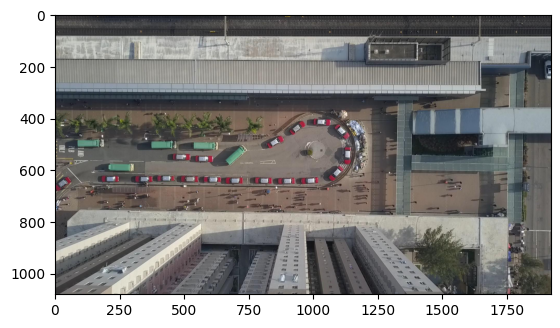

In [43]:
img_path = "/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00055/00001.jpg"
plt.imshow(Image.open(img_path))

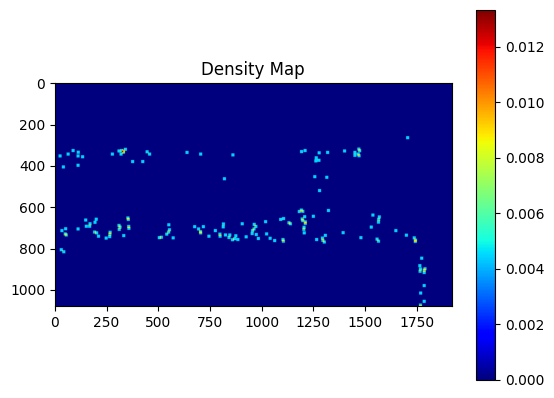

In [44]:
# 正确的路径
h5_path = "/content/drive/MyDrive/VisDrone2020-CC/train/ground_truth/00055/00001.h5"

# 读取 h5 文件
with h5py.File(h5_path, 'r') as gt_file:
    groundtruth = np.asarray(gt_file['density'])  # 读取密度图数据

# 显示密度图
plt.imshow(groundtruth, cmap=CM.jet)
plt.colorbar()  # 添加颜色条
plt.title("Density Map")
plt.show()

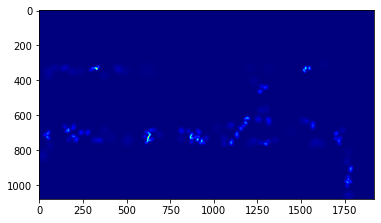

In [ ]:
gt_file = h5py.File(files[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

Processing: /content/drive/MyDrive/VisDrone2020-CC/train/sequences/00055/00012.jpg
Using annotation file: /content/drive/MyDrive/VisDrone2020-CC/train/annotations/00055.txt
(1080, 1920)
Generating density map...
Done.
Processing Time: 36.72739863395691 seconds
Saving .h5 file at: /content/00012.h5
164.62936


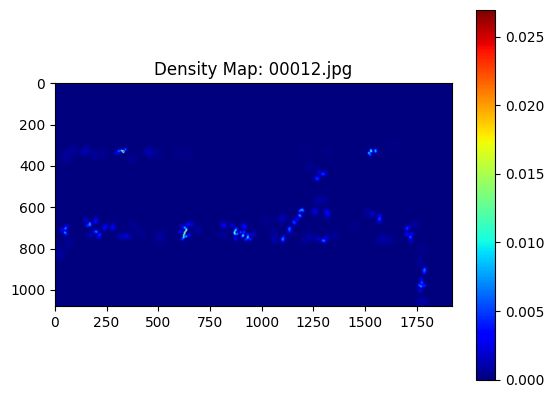

In [9]:
# 设定你要处理的目标图片
target_img_path = "/content/drive/MyDrive/VisDrone2020-CC/train/sequences/00055/00012.jpg"  # 这里改成你要处理的图片路径

# 读取图像
img = plt.imread(target_img_path)
print("Processing:", target_img_path)

# 创建密度图矩阵
k = np.zeros((img.shape[0], img.shape[1]))

# ✅ 计算正确的 `annotations` 文件路径
sequence_folder = os.path.basename(os.path.dirname(target_img_path))  # 提取 `00110`
annotation_file = os.path.join("/content/drive/MyDrive/VisDrone2020-CC/train/annotations", sequence_folder + ".txt")
print("Using annotation file:", annotation_file)

# 确保 `annotation_file` 存在
if not os.path.exists(annotation_file):
    raise FileNotFoundError(f"Error: Annotation file not found: {annotation_file}")

# 读取标注信息
with open(annotation_file, "r") as f:
    lines = f.readlines()

# 提取图片编号（去除前导0）
annotation_id = os.path.basename(target_img_path).replace(".jpg", "").lstrip("0")
if annotation_id == "":
    annotation_id = "0"  # 处理特殊情况

# 解析标注文件
for line in lines:
    line = list(map(int, line.strip().split(",")))
    if line[0] == int(annotation_id):  # 确保当前图片的标注数据
        x, y = line[1], line[2]
        if 0 <= x < k.shape[1] and 0 <= y < k.shape[0]:  # 防止索引超出边界
            k[y, x] = 1

# 进行高斯滤波
start_time = time.time()
#k = gaussian_filter(k, 15)  # 生成密度图
k = gaussian_filter_density2(k)
print("Processing Time: %s seconds" % (time.time() - start_time))

root = '/content/'
# ✅ 现在 `.h5` 文件存放在根目录（如 `/content/00001.h5`）
h5_filename = os.path.basename(target_img_path).replace('.jpg', '.h5')  # 只取文件名

h5_path = os.path.join(root, h5_filename)  # 直接存放在根目录
print("Saving .h5 file at:", h5_path)

# 保存密度图到 `.h5`
with h5py.File(h5_path, 'w') as hf:
    hf['density'] = k

# 读取并可视化密度图
with h5py.File(h5_path, 'r') as gt_file:
    groundtruth = np.asarray(gt_file['density'])
print(np.sum(groundtruth))
plt.imshow(groundtruth, cmap=CM.jet)
plt.colorbar()
plt.title(f"Density Map: {os.path.basename(target_img_path)}")
plt.show()